In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def parse(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(record, keys_to_features)
    image = tf.io.decode_raw(parsed["image_raw"], tf.uint8)
    #image = tf.io.decode_image(parsed["image_raw"],dtype=tf.dtypes.uint8)
    
    image = tf.cast(image, tf.float32) 
    #tf.print(image)
    image = tf.reshape(image, shape=[256, 256, 3])
    
    #print(type(image))
    #print(image.shape)
    image=random_jitter(image)
    image=normalize(image)

    label = tf.cast(parsed["label"], tf.int32)

    return  image


def testparse(this):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64)
    }
    parsed = tf.io.parse_single_example(this, keys_to_features)
    image = tf.io.decode_raw(parsed["image_raw"], tf.uint8)
    #image = tf.io.decode_image(parsed["image_raw"],dtype=tf.dtypes.uint8)
    
    image = tf.cast(image, tf.float32) 
    #tf.print(image)
    image = tf.reshape(image, shape=[256, 256, 3])
    image=normalize(image)
    label = tf.cast(parsed["label"], tf.int32)

    return  image



def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[256, 256, 3])
    return cropped_image


# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
def random_jitter(image):
    
  # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

  # random mirroring
    image = tf.image.random_flip_left_right(image)
    print(type(image))
    return image

def loaddataset(filename):
    dataset=tf.data.TFRecordDataset(filename)
    dataset=dataset.map(parse,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(1000).batch(1)
    #dataset=dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
def loadvideodataset(filename):
    dataset=tf.data.TFRecordDataset(filename)
    dataset=dataset.map(testparse,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset
    
datasetA =loaddataset("dataAtrain.tfrecords")
datasetB=loaddataset("dataBtrain.tfrecords")

#print(count)
#print(videodata)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


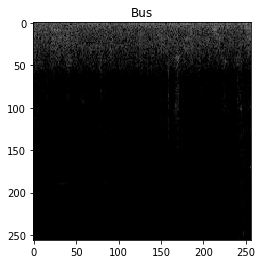

In [27]:
sampleA = next(iter(datasetA))
sampleB=next(iter(datasetB))

plt.subplot(111)
plt.title("Bus")
plt.imshow(sampleA[0] * 0.5 + 0.5)

In [28]:
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


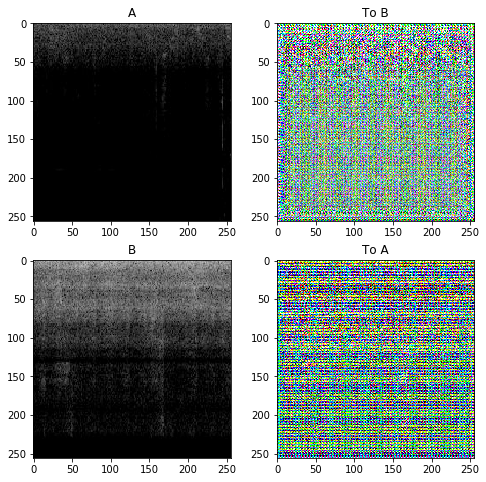

In [29]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


to_B = generator_g(sampleA)
to_A = generator_f(sampleB)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sampleA, to_B, sampleB, to_A]
title = ['A', 'To B', 'B', 'To A']

for i in range(len(imgs)): 
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

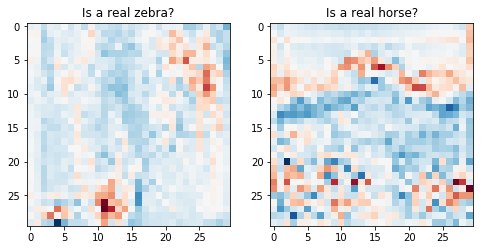

In [5]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sampleB)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sampleA)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [6]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [7]:
checkpoint_path = "AudioCheckpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [13]:
from PIL import Image
import os

EPOCHS = 1

try:
    if not os.path.exists('Mpletsas-GIJOE'):
        os.makedirs('Mpletsas-GIJOE')
except OSError:
    print ('Error: Creating directory of data')


def generate_images(model, test_input,count):
    prediction = model(test_input)
    #im = Image.fromarray(prediction* 0.5 + 0.5)
    inputimage= str("AudioInput") + str(count)+'.jpg'
    predictedimage= str("AudioPredicted") + str(count)+'.jpg'
    print ('Creating...' + predictedimage)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imsave(inputimage,display_list[0] * 0.5 + 0.5)
        plt.imsave(predictedimage,display_list[1] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [14]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
    
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
    
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((datasetA, datasetB)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
    generate_images(generator_g, sampleA)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Creating...AudioPredicted0.jpg


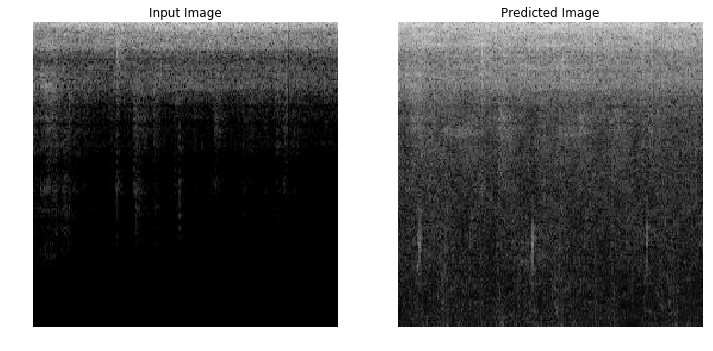

[-80] [0] [bus-vienna-38-1129-s30]
Creating...AudioPredicted1.jpg


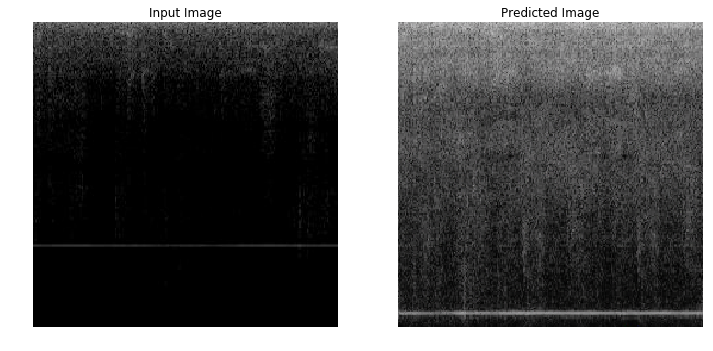

[-80] [0] [bus-stockholm-218-6570-c3]
Creating...AudioPredicted2.jpg


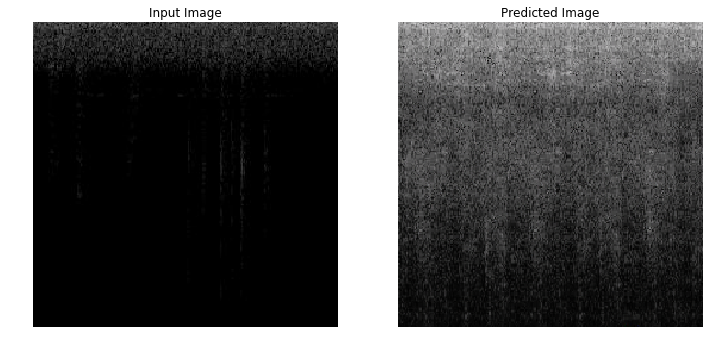

[-80] [0] [bus-vienna-38-1128-a2]
Creating...AudioPredicted3.jpg


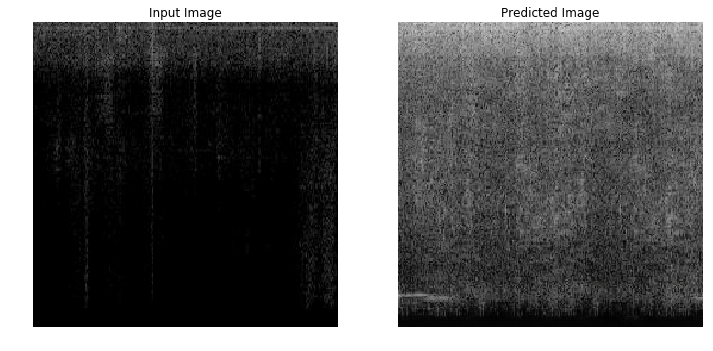

[-80] [0] [bus-stockholm-37-1112-a0]
Creating...AudioPredicted4.jpg


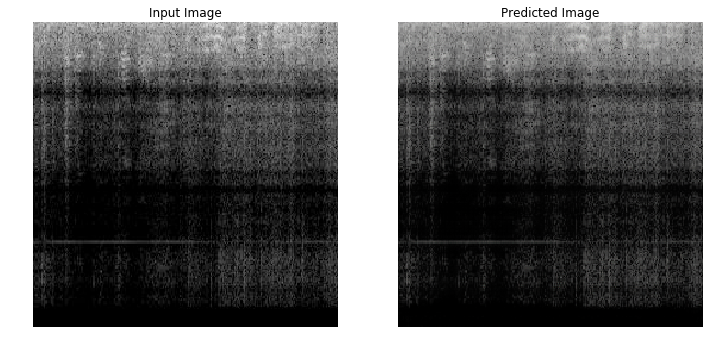

[-80] [0] [bus-stockholm-218-6571-s21]


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def parse(record):
    keys_to_features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64),
        'minimum':tf.io.FixedLenFeature([], tf.int64),
        'maximum':tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(record, keys_to_features)
    image = tf.io.decode_raw(parsed["image_raw"], tf.uint8)
    #image = tf.io.decode_image(parsed["image_raw"],dtype=tf.dtypes.uint8)
    
    image = tf.cast(image, tf.float32) 
    #tf.print(image)
    image = tf.reshape(image, shape=[256, 256, 3])
    
    #print(type(image))
    #print(image.shape)
    image=random_jitter(image)
    image=normalize(image)

    label = parsed['label']
    minimum=parsed['minimum']
    maximum=parsed['maximum']
    filename=parsed['filename']

    return  image,minimum,maximum,filename

def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[256, 256, 3])
    return cropped_image


# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
def random_jitter(image):
    
  # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

  # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

def loaddataset(filename1):
    dataset=tf.data.TFRecordDataset(filename1)
    dataset=dataset.map(parse,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(1000).batch(1)
    #dataset=dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
    

testdatasetA=loaddataset("Bustest.tfrecords")


# Run the trained model on the test dataset
count=0
    

for x in testdatasetA.take(5):
    flname=str(np.array(x[3])).replace("'","")
    flname=flname.replace("b","",1)
    flname=flname.replace(".jpg","")
    flname=flname.replace("./BusTestImages/","")
    generate_images(generator_g, x[0],count)
    print(np.array(x[1]),np.array(x[2]),flname)
    count=count+1

In [19]:
import librosa
import soundfile
import numpy as np 
from PIL import Image
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

pathname="C:\\Users\\Σεβάκ\\Desktop\\Πτυχιακη\\BusTestSounds\\bus-vienna-38-1129-s30.wav"
y, sr = librosa.load(pathname, sr=44100)
S = np.abs(librosa.stft(y, hop_length=511, n_fft=511))
spectogram = librosa.amplitude_to_db(S=S)
print(spectogram.min(),spectogram.max())
img=Image.open("C:\\Users\\Σεβάκ\\AudioPredicted0.jpg").convert('L')
np_array=np.array(img)
scaled_array=scale_minmax(np_array, spectogram.min(), spectogram.max()).astype(np.float32)
S1=librosa.db_to_amplitude(scaled_array)
print(S1.shape)
print(spectogram.shape)
#FourierTransform=librosa.stft(S,hop_length=511,n_fft=511)
#y_inv = librosa.griffinlim(S1,hop_length=511)
y_out = librosa.istft(S1,hop_length=511 )

soundfile.write("AudioInput0.wav",y,samplerate=44100)
soundfile.write('AudioPredicted0.wav', y_out,samplerate=44100)

-48.238785 31.761215
(256, 256)
(256, 256)


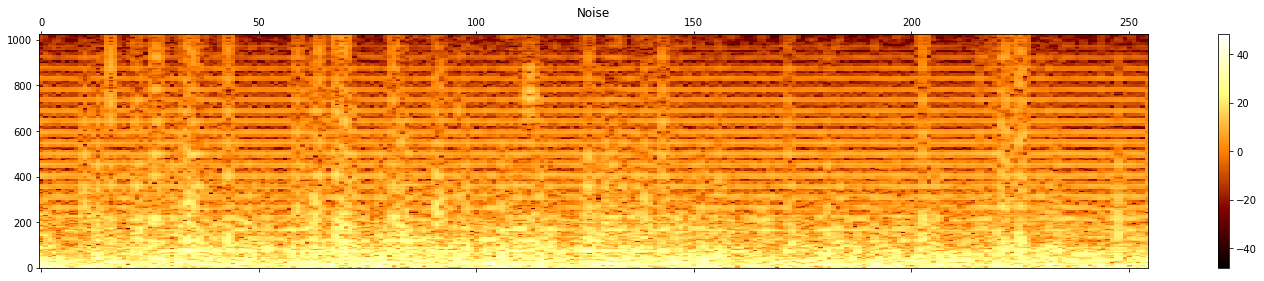

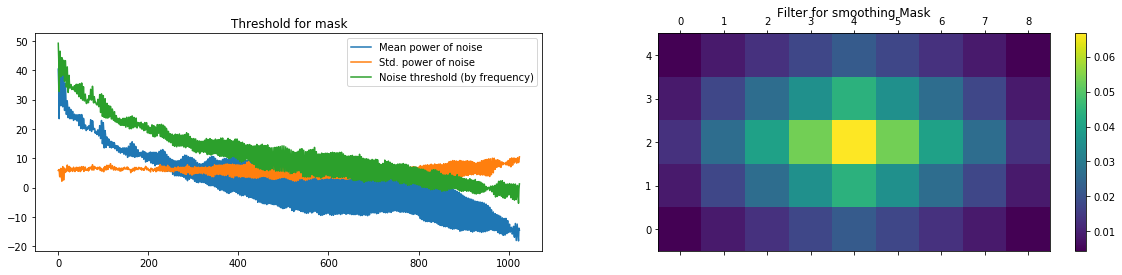

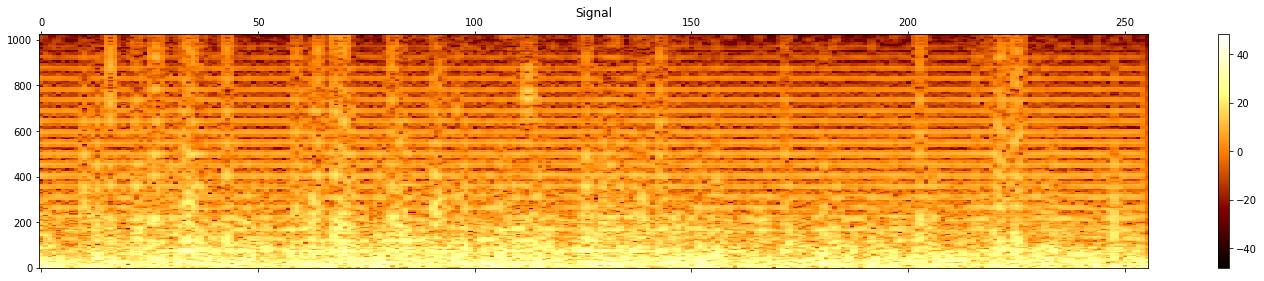

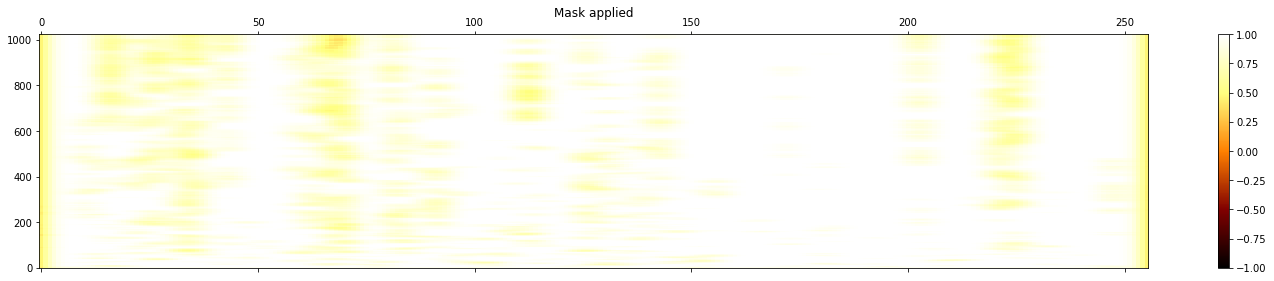

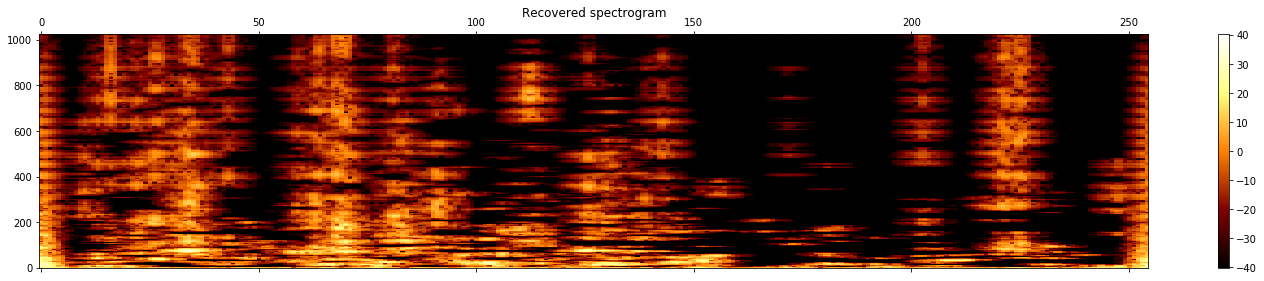

In [21]:
import noisereduce as nr

noise, sr = librosa.load("AudioPredicted0.wav",sr=None)
reduced_noise = nr.reduce_noise(audio_clip=noise, noise_clip=noise,verbose=True)

In [22]:
import IPython
IPython.display.Audio(data=reduced_noise, rate=44100)